# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

**Рассмотрим два варианта проекта без BERT и с BERT**

# Подготовка

## Подключение библиотеки

In [458]:
# Уведомление о завершение работы определенного ячейка (очень пригодится для машинного обучения)
import jupyternotify
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [459]:
# Подключаем все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Для визуализации временных рядов
import plotly.graph_objects
import seaborn as sb
from scipy import stats as st
# Время обучения модели
import timeit
# Тренды и сезонность
from statsmodels.tsa.seasonal import seasonal_decompose
# Проверка на стационарность
from statsmodels.tsa.stattools import adfuller, kpss
# Проверка на дисперсию с помощью теста Андерсона-Дарлинга
from scipy.stats import anderson
# XGBRegressor
import xgboost as xgb

# Работа с текстами
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from lightgbm import LGBMRegressor
# Вызов библиотеки для отключения предупреждения
import warnings

# Разбиение на обучающую, валидационную и тестовую выборку
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, TimeSeriesSplit
# Применим кроссвалидацию для повышения качеств обучения



# Масштабируемость модели
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

# Для машинного обучения разными способами:
# - Логическая регрессия
from sklearn.linear_model import LogisticRegression
# - Случайный лес
from sklearn.ensemble import RandomForestClassifier
# - Решающее дерево
from sklearn.tree import DecisionTreeClassifier
# - Модель на адекватность
from sklearn.dummy import DummyClassifier
# - Бустинг модель
from catboost import CatBoostClassifier

from sklearn.metrics import (
    # Точность модели
    accuracy_score,
    # Матрицы ошибок (для борьбы с дисбалансом)
    confusion_matrix, 
    # Полнота
    recall_score, 
    # Точность
    precision_score, 
    # F1-мера
    f1_score,
    # Метрика AUC-ROC
    roc_auc_score,
    roc_curve,
    # MSE
    mean_squared_error,
    mean_absolute_error,
    fbeta_score, 
    make_scorer
)

# Контроль выборки
from sklearn.utils import shuffle

## Загрузим данные

In [460]:
# Получаем датасет
try:
    # С локального файла
    try:
        # Сразу устанавливаем время как индексы
        df = pd.read_csv('toxic_comments.csv', index_col=[0], parse_dates=[0])
    except:
        df = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0], parse_dates=[0])
except:
    print('Отсутствует датасет. Проверьте путь файла')

## Изучим данные

In [461]:
display(df.info(), df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


None

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Как и видим, что текст написан на английском языке

## Разделим на обучающую и тестовую выборку

In [462]:
# Деление обучающей выборки на признаки и целевые признаки
features = df.drop('toxic', axis=1)
target = df['toxic']

In [463]:
# Разделим обучающую и тестовую выборку
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)

In [464]:
print('Размер обучающей выборки:', round(features_train.shape[0] / df.shape[0], 3), '%')
print('Размер тестовой выборки:', round(features_test.shape[0] / df.shape[0], 3), '%')

Размер обучающей выборки: 0.75 %
Размер тестовой выборки: 0.25 %


## Предобработка данных

In [465]:
# Создаем корпус текстов
corpus_train = features_train['text'].values.astype('U')
corpus_test = features_test['text'].values.astype('U')

In [466]:
print('Corpus_train')
display(corpus_train[0])
print()
print('Corpus_test')
display(corpus_test[0])

Corpus_train


"That makes no sense. You don't play MapleStory through Internet Explorer. Sure, the website can only be accessible through IE (well, you can access it through Firefox as well if you know what to do), but it's not really part of the game."


Corpus_test


'Expert Categorizers  \n\nWhy is there no mention of the fact that Nazis were particularly great categorizers? They excelled in identifying various things and writing about them and putting them in their proper places.'

## Установка стоп-слово

In [467]:
# Получим стоп-слово
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Papin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Создание корпуса текстов с обучающей и тестовой выборки

### Обучающая выборка

In [468]:
# По аналогии с CountVectorizer() создадим счётчик, указав в нём стоп-слова:
count_tf_idf_train = TfidfVectorizer(stop_words=list(stopwords))

In [469]:
# Чтобы посчитать TF-IDF для корпуса текстов, вызовем функцию fit_transform():
tf_idf_train = count_tf_idf_train.fit_transform(corpus_train) 
# Передав TfidfVectorizer() аргумент ngram_range, можно рассчитать N-граммы.

In [470]:
print("Размер матрицы обучающей выборки:", tf_idf_train.shape)

Размер матрицы обучающей выборки: (119469, 158310)


### Тестовая выборка

In [471]:
# По аналогии с CountVectorizer() создадим счётчик, указав в нём стоп-слова:
count_tf_idf_test = TfidfVectorizer(stop_words=list(stopwords))

In [472]:
# Чтобы посчитать TF-IDF для корпуса текстов, вызовем функцию fit_transform():
tf_idf_test = count_tf_idf_train.transform(corpus_test) 
# Передав TfidfVectorizer() аргумент ngram_range, можно рассчитать N-граммы.

In [473]:
print("Размер матрицы тестовой выборки:", tf_idf_test.shape)

Размер матрицы тестовой выборки: (39823, 158310)


# Машинное обучение

In [474]:
# Здесь будем сохранить результаты машинного обучения
results = pd.DataFrame()

# А это будет счетчтиком для нумерация моеделй
count_model = 0

## Функции

**Создаем функцию, которая упрощает написание кода**

### Обучение модели

In [475]:
# Обучение модели
def fit_model(model, tf_idf_train, target_train):
    # Обучим модель на обучающей выборке
    model.fit(tf_idf_train, target_train)

    # Узнаем RMSE обучающей выборки
    F1_TRAIN = model.best_score_
    print('F1 TRAIN:', F1_TRAIN)
    print('TIME TRAIN [s]:', round(model.refit_time_, 3))
    
    return F1_TRAIN

### Предсказание модели

In [476]:
# Предсказание модели
def predict_model(model, tf_idf_test, target_test):
    start_time = timeit.default_timer()
    # Получим предсказания на тестовой выборки
    predictions = model.predict(tf_idf_test)

    elapsed = round(timeit.default_timer() - start_time, 3)

    # Узнаем RMSE
    F1_VALID = f1_score(target_test, predictions)
    print('F1 VALID:', F1_VALID)
    print('Предсказание:', predictions.mean())
    
    return predictions, elapsed, F1_VALID

### Сохранение результатов

In [477]:
# Зафиксируем результаты
def save_result(name, F1_TRAIN, F1_VALID, predictions, refit_time_, elapsed, best_params_, count_model, show_display=False):
    results[count_model] = pd.Series({
        'NAME': f'{name}', 
        'F1 TRAIN': F1_TRAIN, 
        'F1 VALID': F1_VALID, 
        'PREDICTIONS': predictions.mean(), 
        'TIME TRAINING [s]': refit_time_, 
        'TIME PREDICTION [s]': elapsed, 
        'PARAMETRS': best_params_
    })
    
    if(show_display == True): display(results[count_model])

### График ROC-кривая

In [478]:
def display_aus_roc(model, tf_idf_test, target_test):
    probabilities_test = model.predict_proba(tf_idf_test)
    probabilities_one_test = probabilities_test[:, 1]

    auc_roc = roc_auc_score(target_test, probabilities_one_test)

    # Изображаем ROC-кривую
    fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

    plt.figure()

    plt.plot(fpr, tpr)

    plt.plot([0, 1], [0, 1], linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('ROC-кривая')
    plt.show()
    
    print('ROC AUC:', auc_roc)

### График распределения плотности предсказанных и истинных значений

In [479]:
def display_graph_predicted_and_target(target_train, predictions, F1_VALID, x_pos, y_pos):
    plt.figure(figsize=(10, 5))
    # Целевой признак
    target_train.plot(kind='kde', linewidth=2)
    # Предсказания
    pd.Series(predictions).plot(kind='kde',linewidth=2)
    
    plt.title('График распределения плотности предсказанных и истинных значений')
    plt.legend(['Истинные значения','Предсказанные значения'], fontsize='large')
    
    plt.text(x_pos, y_pos, f'F1= {round(F1_VALID, 3)}')
    plt.xlabel('')
    plt.ylabel('Плотность')
    
    plt.show()

## LogisticRegression

In [480]:
# Устанавливаем нужные параметры
parameters = {"C": np.logspace(-3, 3, 10), "penalty": ["l2"]}

# Инициализируем модель
model = GridSearchCV(LogisticRegression(solver='lbfgs', max_iter=1000), param_grid = parameters, cv = 5, scoring = 'f1')

In [481]:
%%notify -m 'LogisticRegression'
%%time

# Обучение модели
F1_TRAIN = fit_model(model, tf_idf_train, target_train)

F1 TRAIN: 0.7582260326033147
TIME TRAIN [s]: 9.809
CPU times: total: 35min 59s
Wall time: 6min 46s


<IPython.core.display.Javascript object>

### Проверка на тестовой выборки

In [482]:
%%time
# Предсказание модели
predictions, elapsed, F1_VALID = predict_model(model, tf_idf_test, target_test)

F1 VALID: 0.7795374912403643
Предсказание: 0.07761846169299148
CPU times: total: 93.8 ms
Wall time: 47.5 ms


In [483]:
# Зафиксируем результаты
save_result('LogisticRegression', F1_TRAIN, F1_VALID, predictions, model.refit_time_, elapsed, model.best_params_, count_model, show_display=True)
count_model+=1

NAME                             LogisticRegression
F1 TRAIN                                   0.758226
F1 VALID                                   0.779537
PREDICTIONS                                0.077618
TIME TRAINING [s]                           9.80854
TIME PREDICTION [s]                           0.011
PARAMETRS              {'C': 10.0, 'penalty': 'l2'}
Name: 0, dtype: object

### ROC-кривая

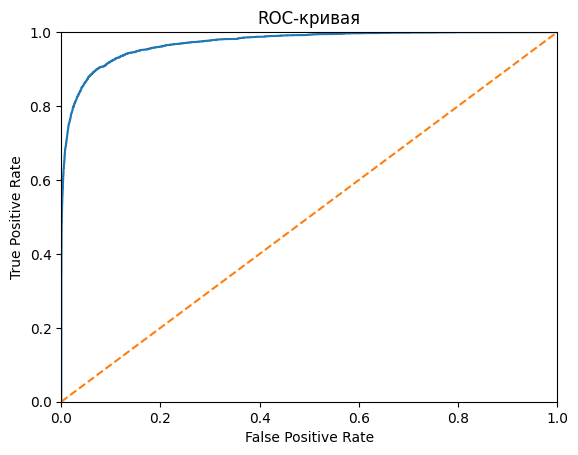

ROC AUC: 0.9714302950116704


In [484]:
display_aus_roc(model, tf_idf_test, target_test)

_*Примечание*_

Интервал AUC и качество модели
- 0,9 - 1,0 Отличное
- 0,8 - 0,9 Очень хорошее
- 0,7 - 0,8 Хорошее
- 0,6 - 0,7 Среднее
- 0,5 - 0,6 Неудовлетворительное

Здесь значение ROC-AUC получилось очень идеальной, близок к 1

### График распределения плотности предсказанных и истинных значений

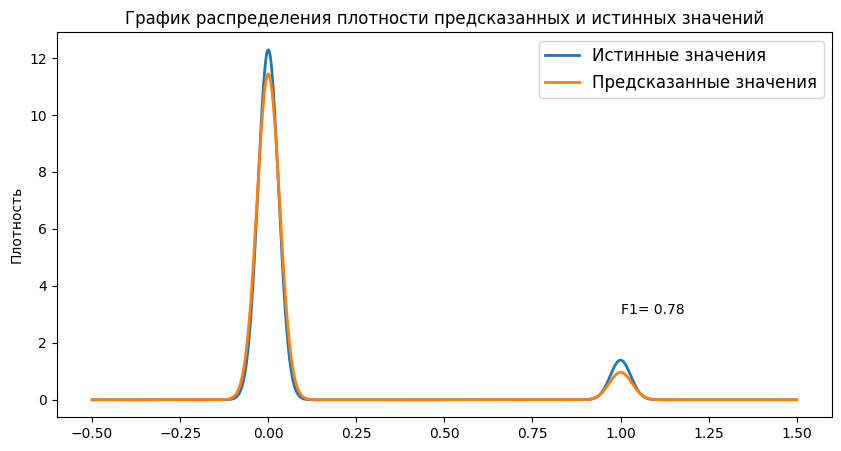

In [485]:
display_graph_predicted_and_target(target_train, predictions, F1_VALID, 1, 3)

Результат оказался оптимальным, т.е. F1 = 0,778 

## RandomForestClassifier

In [486]:
# Устанавливаем нужные параметры
parameters = {
    'n_estimators': [10, 20],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'max_depth':[5, 20]
}

# Инициализируем модель
model = GridSearchCV(RandomForestClassifier(random_state=12345), param_grid = parameters, cv = 5, scoring = 'f1')

In [487]:
%%notify -m 'RandomForestClassifier'
%%time

# Обучение модели
F1_TRAIN = fit_model(model, tf_idf_train, target_train)

F1 TRAIN: 0.006390575965808836
TIME TRAIN [s]: 2.051
CPU times: total: 6min 26s
Wall time: 6min 42s


<IPython.core.display.Javascript object>

### Проверка на тестовой выборки

In [488]:
%%time
# Предсказание модели
predictions, elapsed, F1_VALID = predict_model(model, tf_idf_test, target_test)

F1 VALID: 0.01958863858961802
Предсказание: 0.0010044446676543705
CPU times: total: 141 ms
Wall time: 149 ms


F1 метрика совсем сильно упала, почти в 100 раз, очень странно получилось, дальше смотрим

In [489]:
# Зафиксируем результаты
save_result('RandomForestClassifier', F1_TRAIN, F1_VALID, predictions, model.refit_time_, elapsed, model.best_params_, count_model, show_display=True)
count_model+=1

NAME                                              RandomForestClassifier
F1 TRAIN                                                        0.006391
F1 VALID                                                        0.019589
PREDICTIONS                                                     0.001004
TIME TRAINING [s]                                                2.05133
TIME PREDICTION [s]                                                0.125
PARAMETRS              {'bootstrap': True, 'max_depth': 20, 'max_feat...
Name: 1, dtype: object

### ROC-кривая

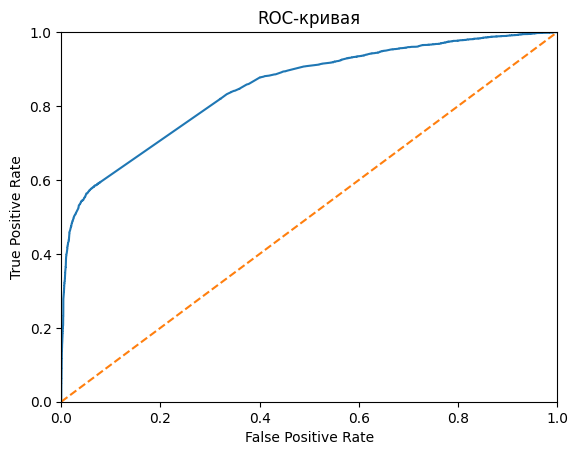

ROC AUC: 0.8487475136200583


In [490]:
display_aus_roc(model, tf_idf_test, target_test)

_*Примечание*_

Интервал AUC и качество модели
- 0,9 - 1,0 Отличное
- 0,8 - 0,9 Очень хорошее
- 0,7 - 0,8 Хорошее
- 0,6 - 0,7 Среднее
- 0,5 - 0,6 Неудовлетворительное

Здесь значение ROC-AUC получилось хорошей, около 0,84

### График распределения плотности предсказанных и истинных значений

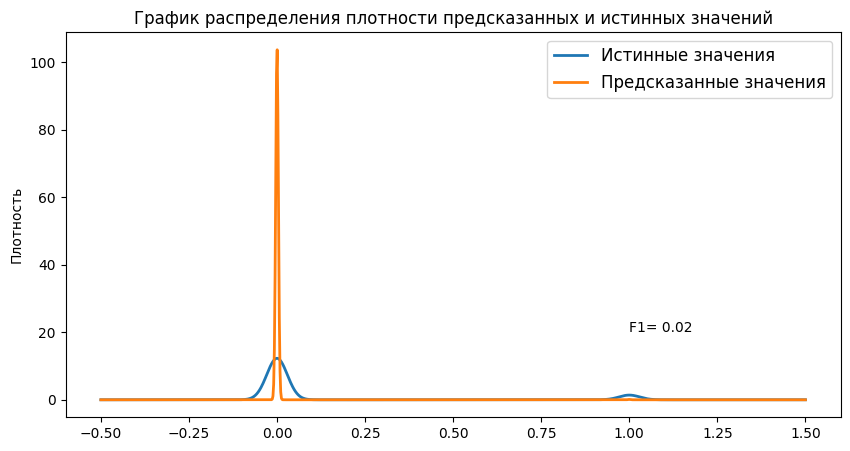

In [491]:
display_graph_predicted_and_target(target_train, predictions, F1_VALID, 1, 20)

Результат у моделей Случайного леса оказался намного худшим по сравнению с остальными моделями

## DecisionTreeClassifier

In [492]:
# Устанавливаем нужные параметры
parameters = {'max_depth': range(1, 51, 10), 'min_samples_leaf': [0.5, 1]}

# Инициализируем модель
model = GridSearchCV(DecisionTreeClassifier(random_state=12345), param_grid = parameters, cv = 5, scoring = 'f1')

In [493]:
%%notify -m 'DecisionTreeClassifier'
%%time

# Обучение модели
F1_TRAIN = fit_model(model, tf_idf_train, target_train)

F1 TRAIN: 0.6874631889769903
TIME TRAIN [s]: 32.837
CPU times: total: 11min 58s
Wall time: 12min 51s


<IPython.core.display.Javascript object>

### Проверка на тестовой выборки

In [494]:
%%time
# Предсказание модели
predictions, elapsed, F1_VALID = predict_model(model, tf_idf_test, target_test)

F1 VALID: 0.6881466154300916
Предсказание: 0.06835245963387993
CPU times: total: 0 ns
Wall time: 48 ms


In [495]:
# Зафиксируем результаты
save_result('DecisionTreeClassifier', F1_TRAIN, F1_VALID, predictions, model.refit_time_, elapsed, model.best_params_, count_model, show_display=True)
count_model+=1

NAME                                     DecisionTreeClassifier
F1 TRAIN                                               0.687463
F1 VALID                                               0.688147
PREDICTIONS                                            0.068352
TIME TRAINING [s]                                     32.837006
TIME PREDICTION [s]                                       0.019
PARAMETRS              {'max_depth': 41, 'min_samples_leaf': 1}
Name: 2, dtype: object

### ROC-кривая

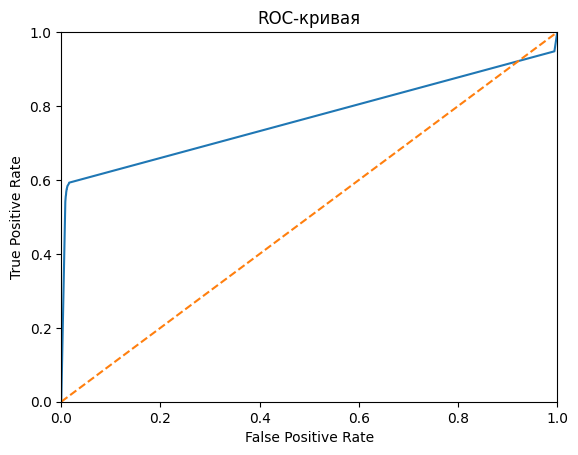

ROC AUC: 0.7659905389910239


In [496]:
display_aus_roc(model, tf_idf_test, target_test)

_*Примечание*_

Интервал AUC и качество модели
- 0,9 - 1,0 Отличное
- 0,8 - 0,9 Очень хорошее
- 0,7 - 0,8 Хорошее
- 0,6 - 0,7 Среднее
- 0,5 - 0,6 Неудовлетворительное

Здесь значение ROC-AUC тоже получилось хорошей, около 0,76

### График распределения плотности предсказанных и истинных значений

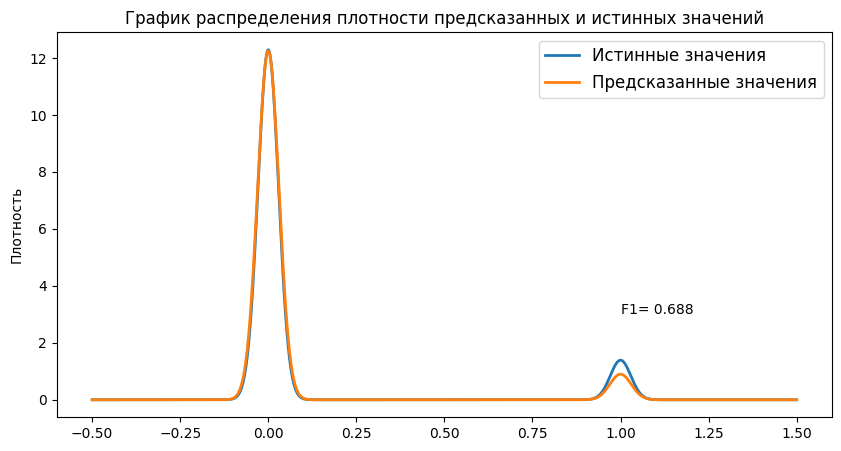

In [497]:
display_graph_predicted_and_target(target_train, predictions, F1_VALID, 1, 3)

Результат у моделей Решающего дерева тоже оказался неплохим, но логическая регрессия лучше

## CatBoostClassifier

In [498]:
# Устанавливаем нужные параметры
parameters = {
    'depth' : [5, 10],
    'learning_rate' : [0.01, 0.1],
    'iterations' : [10, 20]
}

# Инициализируем модель
model = GridSearchCV(CatBoostClassifier(), param_grid = parameters, cv = 5, scoring = 'f1')

In [499]:
%%notify -m 'CatBoostClassifier'
%%time

# Обучение модели
F1_TRAIN = fit_model(model, tf_idf_train, target_train)

0:	learn: 0.6822488	total: 758ms	remaining: 6.83s
1:	learn: 0.6719067	total: 1.3s	remaining: 5.18s
2:	learn: 0.6615419	total: 1.85s	remaining: 4.32s
3:	learn: 0.6517941	total: 2.4s	remaining: 3.6s
4:	learn: 0.6418862	total: 2.96s	remaining: 2.96s
5:	learn: 0.6327369	total: 3.5s	remaining: 2.33s
6:	learn: 0.6233554	total: 4.08s	remaining: 1.75s
7:	learn: 0.6144739	total: 4.62s	remaining: 1.15s
8:	learn: 0.6055799	total: 5.17s	remaining: 574ms
9:	learn: 0.5970627	total: 5.71s	remaining: 0us
0:	learn: 0.6828172	total: 540ms	remaining: 4.86s
1:	learn: 0.6724845	total: 1.07s	remaining: 4.28s
2:	learn: 0.6623832	total: 1.59s	remaining: 3.71s
3:	learn: 0.6525792	total: 2.1s	remaining: 3.16s
4:	learn: 0.6430937	total: 2.65s	remaining: 2.65s
5:	learn: 0.6339699	total: 3.29s	remaining: 2.19s
6:	learn: 0.6246325	total: 3.85s	remaining: 1.65s
7:	learn: 0.6160882	total: 4.41s	remaining: 1.1s
8:	learn: 0.6073531	total: 4.97s	remaining: 553ms
9:	learn: 0.5988782	total: 5.51s	remaining: 0us
0:	learn: 

5:	learn: 0.6331300	total: 3.39s	remaining: 7.91s
6:	learn: 0.6239787	total: 3.92s	remaining: 7.28s
7:	learn: 0.6150993	total: 4.46s	remaining: 6.68s
8:	learn: 0.6063398	total: 5s	remaining: 6.11s
9:	learn: 0.5978518	total: 5.55s	remaining: 5.55s
10:	learn: 0.5896246	total: 6.12s	remaining: 5s
11:	learn: 0.5817069	total: 6.65s	remaining: 4.43s
12:	learn: 0.5738949	total: 7.17s	remaining: 3.86s
13:	learn: 0.5659738	total: 7.7s	remaining: 3.3s
14:	learn: 0.5585138	total: 8.29s	remaining: 2.77s
15:	learn: 0.5508736	total: 9.01s	remaining: 2.25s
16:	learn: 0.5436473	total: 9.76s	remaining: 1.72s
17:	learn: 0.5363976	total: 10.3s	remaining: 1.15s
18:	learn: 0.5297322	total: 10.9s	remaining: 574ms
19:	learn: 0.5232261	total: 11.4s	remaining: 0us
0:	learn: 0.6823076	total: 563ms	remaining: 10.7s
1:	learn: 0.6718411	total: 1.08s	remaining: 9.75s
2:	learn: 0.6620349	total: 1.63s	remaining: 9.24s
3:	learn: 0.6520123	total: 2.17s	remaining: 8.7s
4:	learn: 0.6421724	total: 2.78s	remaining: 8.35s
5

9:	learn: 0.5952489	total: 1m 43s	remaining: 0us
0:	learn: 0.6824281	total: 10.6s	remaining: 1m 35s
1:	learn: 0.6720151	total: 21.7s	remaining: 1m 26s
2:	learn: 0.6613014	total: 32.2s	remaining: 1m 15s
3:	learn: 0.6509707	total: 42.6s	remaining: 1m 3s
4:	learn: 0.6410985	total: 53.2s	remaining: 53.2s
5:	learn: 0.6313084	total: 1m 3s	remaining: 42.3s
6:	learn: 0.6213215	total: 1m 13s	remaining: 31.5s
7:	learn: 0.6119940	total: 1m 23s	remaining: 20.9s
8:	learn: 0.6031351	total: 1m 33s	remaining: 10.4s
9:	learn: 0.5948444	total: 1m 44s	remaining: 0us
0:	learn: 0.6822976	total: 10.7s	remaining: 1m 36s
1:	learn: 0.6714133	total: 21.1s	remaining: 1m 24s
2:	learn: 0.6609335	total: 31.2s	remaining: 1m 12s
3:	learn: 0.6509463	total: 41.4s	remaining: 1m 2s
4:	learn: 0.6409306	total: 51.7s	remaining: 51.7s
5:	learn: 0.6310143	total: 1m 1s	remaining: 41.2s
6:	learn: 0.6218615	total: 1m 12s	remaining: 31.1s
7:	learn: 0.6127230	total: 1m 22s	remaining: 20.7s
8:	learn: 0.6037838	total: 1m 33s	remaini

10:	learn: 0.5861026	total: 1m 56s	remaining: 1m 35s
11:	learn: 0.5777336	total: 2m 6s	remaining: 1m 24s
12:	learn: 0.5695842	total: 2m 17s	remaining: 1m 13s
13:	learn: 0.5613453	total: 2m 27s	remaining: 1m 3s
14:	learn: 0.5533554	total: 2m 37s	remaining: 52.6s
15:	learn: 0.5457731	total: 2m 48s	remaining: 42.2s
16:	learn: 0.5381613	total: 3m 1s	remaining: 31.9s
17:	learn: 0.5310285	total: 3m 12s	remaining: 21.4s
18:	learn: 0.5236949	total: 3m 22s	remaining: 10.7s
19:	learn: 0.5170482	total: 3m 33s	remaining: 0us
0:	learn: 0.5916653	total: 10.2s	remaining: 3m 14s
1:	learn: 0.5135448	total: 20.7s	remaining: 3m 6s
2:	learn: 0.4507276	total: 31s	remaining: 2m 55s
3:	learn: 0.4003768	total: 42.9s	remaining: 2m 51s
4:	learn: 0.3629074	total: 55.6s	remaining: 2m 46s
5:	learn: 0.3335529	total: 1m 5s	remaining: 2m 33s
6:	learn: 0.3106396	total: 1m 16s	remaining: 2m 22s
7:	learn: 0.2911565	total: 1m 27s	remaining: 2m 10s
8:	learn: 0.2765907	total: 1m 37s	remaining: 1m 59s
9:	learn: 0.2641253	to

<IPython.core.display.Javascript object>

### Проверка на тестовой выборки

In [500]:
%%time
# Предсказание модели
predictions, elapsed, F1_VALID = predict_model(model, tf_idf_test, target_test)

F1 VALID: 0.5572331460674157
Предсказание: 0.04148356477412551
CPU times: total: 1.05 s
Wall time: 577 ms


In [501]:
# Зафиксируем результаты
save_result('CatBoostClassifier', F1_TRAIN, F1_VALID, predictions, model.refit_time_, elapsed, model.best_params_, count_model, show_display=True)
count_model+=1

NAME                                                  CatBoostClassifier
F1 TRAIN                                                        0.562688
F1 VALID                                                        0.557233
PREDICTIONS                                                     0.041484
TIME TRAINING [s]                                              279.01843
TIME PREDICTION [s]                                                0.547
PARAMETRS              {'depth': 10, 'iterations': 20, 'learning_rate...
Name: 3, dtype: object

### ROC-кривая

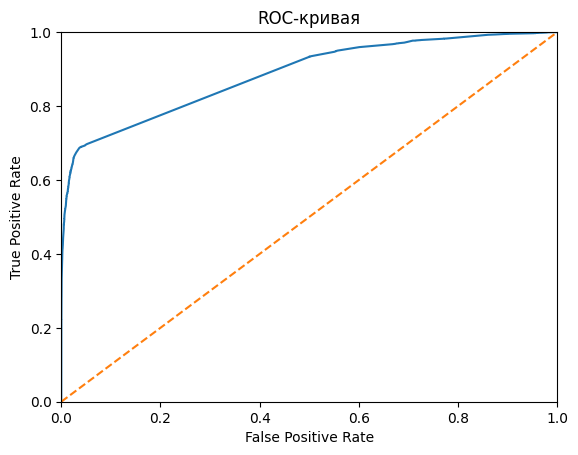

ROC AUC: 0.8854663909826256


In [502]:
display_aus_roc(model, tf_idf_test, target_test)

_*Примечание*_

Интервал AUC и качество модели
- 0,9 - 1,0 Отличное
- 0,8 - 0,9 Очень хорошее
- 0,7 - 0,8 Хорошее
- 0,6 - 0,7 Среднее
- 0,5 - 0,6 Неудовлетворительное

Здесь значение ROC-AUC тоже получилось очень хорошей, около 0,88

### График распределения плотности предсказанных и истинных значений

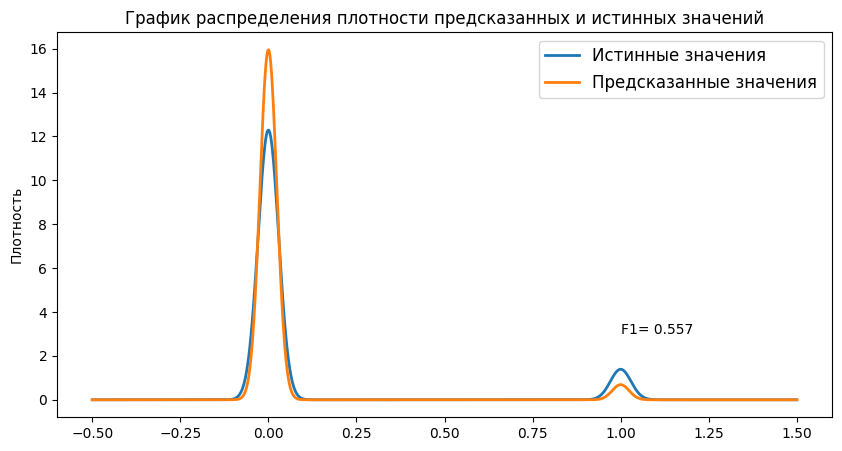

In [503]:
display_graph_predicted_and_target(target_train, predictions, F1_VALID, 1, 3)

Результат у моделей Бустинга тоже оказался неплохим, но все равно логическая регрессия лучше

# Вывод

In [508]:
%%notify -m "Total result"
results = pd.DataFrame(results).T

<IPython.core.display.Javascript object>

In [509]:
# Смотрим все результаты обучения
results

,NAME,F1 TRAIN,F1 VALID,PREDICTIONS,TIME TRAINING [s],TIME PREDICTION [s],PARAMETRS
0,LogisticRegression,0.758226,0.779537,0.077618,9.80854,0.011,"{'C': 10.0, 'penalty': 'l2'}"
1,RandomForestClassifier,0.006391,0.019589,0.001004,2.05133,0.125,"{'bootstrap': True, 'max_depth': 20, 'max_feat..."
2,DecisionTreeClassifier,0.687463,0.688147,0.068352,32.837006,0.019,"{'max_depth': 41, 'min_samples_leaf': 1}"
3,CatBoostClassifier,0.562688,0.557233,0.041484,279.01843,0.547,"{'depth': 10, 'iterations': 20, 'learning_rate..."


In [511]:
# Нам интересует F1 не менее 0.75, тогда
best_results = results[results['F1 VALID'] > 0.75]
best_results

,NAME,F1 TRAIN,F1 VALID,PREDICTIONS,TIME TRAINING [s],TIME PREDICTION [s],PARAMETRS
0,LogisticRegression,0.758226,0.779537,0.077618,9.80854,0.011,"{'C': 10.0, 'penalty': 'l2'}"


Самой лучшей моделей является LogisticRegression - F1 на тестовой выборки составляет `0.77`, а скорость обучения составляет аж **10 секунды**, время предсказания - **0,01 секунда**. 

Вполне очень акдеватный результат, чтобы выбрать эту модель для реализации. 

Есть другая модель, но, к сожалению, не попал в топ, т.к. метрика F1 ниже заявленного - `0,75`.

# Машинное обучение с BERT

## Установка библиотеки

In [412]:
import os
import shutil

# Библиотеки для обучения с применением технологий BERT
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from transformers import BertTokenizer
# Чтобы создать AdamW оптимизацию
from official.nlp import optimization  

tf.get_logger().setLevel('ERROR')

## Получение датасета

In [367]:
# Получаем csv файл через ссылки
toxic_comments_path = tf.keras.utils.get_file("toxic_comments.csv", 'https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [368]:
# Адрес хранения csv файла
toxic_comments_path

'C:\\Users\\Papin\\.keras\\datasets\\toxic_comments.csv'

In [434]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

toxic_comments_csv_ds = tf.data.experimental.make_csv_dataset(
    'toxic_comments.csv',
    label_name='',
    batch_size=batch_size,
    num_epochs=1,
    ignore_errors=True)

Просмотр текстов

In [435]:
for batch, label in toxic_comments_csv_ds.take(1):
    for key, value in batch.items():
        print(f"{key:20s}: {value}")
        print('-'*127)
    print('='*127)
    print('')
    print(f"{'label':20s}: {label}")

text                : [b"I don't understand your use of English, please be more clear. Anything abusive or pornographic must have been added by a different user. I looked at the edit history and found nothing distressing, I only restored what was there before without adding anything that might distress you or anybody else. If restoring the relationship distresses you because you have a personal issue with the person who originally added it in which is distressing to you, I appolegies, but I insist that added no distressing content.\n\nAlso, please show me this consensus. It was not listed on the talk page and there was no link to it. Unless I have a link, I am afraid that I can take this as nothing but your words which I can take no other way than being words."
 b'Mereger? \n\nPlease explain why you merged an article which was deleted into this article? Most of it is OR and has no place in an article whatsoever.'
 b'pervert, \n\nps karl swithwnbank wrothe this not littledan9999'
 b"Sal

In [436]:
toxic_comments_csv_ds

<PrefetchDataset element_spec=(OrderedDict([('text', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('toxic', TensorSpec(shape=(None,), dtype=tf.int32, name=None))]), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

##  Деление на обучающей и тестовой выборки

In [437]:
# Разделим обучающую и валидцаионную, тестовую выборку в соотношение 60:40
train, test = train_test_split(df, test_size=0.2, random_state=12345)

In [438]:
print('Размер обучающей выборки:', round(train.shape[0] / df.shape[0], 3), '%')
print('Размер тестовой выборки:', round(test.shape[0] / df.shape[0], 3), '%')

Размер обучающей выборки: 0.8 %
Размер тестовой выборки: 0.2 %


In [439]:
# Cохраняим файлы
train.to_csv(r"toxic_comments_train.csv")
test.to_csv(r"toxic_comments_test.csv")

In [440]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

toxic_comments_csv_ds_train = tf.data.experimental.make_csv_dataset(
    'toxic_comments_train.csv',
    label_name='',
    batch_size=batch_size,
    num_epochs=1,
    ignore_errors=True)

toxic_comments_csv_ds_test = tf.data.experimental.make_csv_dataset(
    'toxic_comments_test.csv',
    label_name='',
    batch_size=batch_size,
    num_epochs=1,
    ignore_errors=True)

Просмотр текстов обучающей выборки

In [441]:
for batch, label in toxic_comments_csv_ds_train.take(1):
    for key, value in batch.items():
        print(f"{key:20s}: {value}")
        print('-'*127)
    print('='*127)
    print('')
    print(f"{'label':20s}: {label}")

text                : [b"Hello \n\nI just thought I'd let you know that I say your article Architectural Science Review in the New Articles listThe information is presented clearly and is easy to understand. However, I think the article seems to contain a few errors: the article does not contain in-line citations, and so doesn't follow Wikipedia style guidelines.\nIt would be great if you could also improve the related article List of academic journals."
 b'"\n\n 8 reverts \n\nI did not make any reverts. The 8 reverts I was talking about was done by Levine2112.  "'
 b'"\n I won\'t appeal this block, but at least make this a fair block by blocking that nuisance yourself. He started it with that mocking.  Holla at me!  "'
 b'i didnt think you would have a response for that'
 b'" 2009 (UTC)\nTemplating The 500 Greatest Songs of All Time\nThanks for soliciting my opinion. There seems to be little support for adding awards and such to infoboxes:\nInfobox Musical artist\nAnd templates for aw

Просмотр текстов тестовой выборки

In [442]:
for batch, label in toxic_comments_csv_ds_test.take(1):
    for key, value in batch.items():
        print(f"{key:20s}: {value}")
        print('-'*127)
    print('='*127)
    print('')
    print(f"{'label':20s}: {label}")

text                : [b"Good to know! I'll start removing the information that doesn't have a source. The president of our organization recently published an Op-Ed in the local newspaper. Can I use that as a source? \nIt's really cool to hear that you're the one that started The Tech Awards article. I'll try to find more sources, so that it can be updated."
 b'"\n\n Image placement \n\nPlease stop adding irrelevant images such as a screenshot of the homepage of a company into pages. Additionally, your replacement of the official CBS logo with a JPEG artifact-riddled version is completely inappropriate. See the image use policy here on Wikipedia to give you an overview of what is appropriate to add into articles and what is not. Thank you. \'\'\'\'\'\'\'\'\'\'talk "'
 b'Stop harassing me please \nStyrofoam1994 please stop harassing me'
 b'Himani Navratna Oil\n\nNet 50ml\n\nWhat it says: \xe2\x80\x9cGuaranteed 100% Herbal. An Excellent Cool Oil Formulated by Rabindra Puraskar Winner Lat

## Загрузка моделей с TensorFlow HUB

In [443]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## Модель предварительной обработки

In [444]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [445]:
corpus_train[0]

'"\nThe First Division is included, but only for years when it was the top tier of English football. The top tier is the only relevant level. If you want to include Second Division titles, you\'re really only acknowledging that one club was in the Second Division longer than the other, and that\'s not anything worth shouting about. And would you please stop talking about ""major"" trophies. They\'re just trophies, there\'s nothing major or minor about them. – Jay "'

In [446]:
text_test = list(corpus_train[0])
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (463, 128)
Word Ids   : [ 101 1000  102    0    0    0    0    0    0    0    0    0]
Input Mask : [1 1 1 0 0 0 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


### Возвращаемые значения

Прежде чем внедрять BERT в вашу собственную модель, нужно сначала взглянуть на ее выходные данные. 

Мы загрузили его из TF Hub, и теперь увидим возвращаемые значения.

In [447]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [448]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(463, 512)
Pooled Outputs Values:[ 0.964834   -0.17843105 -0.25604504 -0.08633736  0.06525536  0.96364266
  0.76323825 -0.8259036  -0.25786063 -0.9997027   0.15350132 -0.99833673]
Sequence Outputs Shape:(463, 128, 512)
Sequence Outputs Values:[[ 1.1880465   0.16548514  0.52010137 ... -1.3935456   0.72548085
   0.4851817 ]
 [ 1.8258715   0.6981835  -0.92007947 ...  0.02137677  1.1609669
   0.11297412]
 [ 1.3568974  -0.37145764  1.0243483  ... -0.6833948   0.30857855
   0.20199293]
 ...
 [ 0.8787285  -0.02032542 -0.4496386  ... -0.18110166  0.92780066
   0.22329672]
 [ 0.87346816  0.26692882 -0.26071578 ... -0.20293932  1.0134312
   0.07956394]
 [ 0.87515575  0.36114353 -0.38098806 ... -0.17099996  0.94220555
   0.06431089]]


**ЛУЧШИЕ модели** возвращают карту с 3 важными ключами: `pooled_output`, `sequence_output`, `encoder_outputs`:

`pooled_output` представляет каждую входную последовательность в целом. Форма - `[batch_size, H]`. Мы можем рассматривать это как встраивание для всего обзора фильма.

`sequence_output` представляет каждый входной токен в контексте. Форма имеет вид `[batch_size, seq_length, H]`. Мы можем думать об этом как о контекстуальном встраивании для каждого токена в обзоре фильма.

`encoder_outputs` - это промежуточные активации блоков `L`-трансформатора. выходные данные `["encoder_outputs"][i]` - это тензор формы `[batch_size, seq_length, 1024]` с выходами i-го блока преобразования, для `0 <= i < L`. Последнее значение списка равно `sequence_output`.

Для точной настройки мы используем массив `pooled_output`.

### Подбор моделей для машинного обучения

Мы создадим очень простую точно настроенную модель с моделью предварительной обработки, выбранной **НАИЛУЧШЕЙ моделью**, одним плотным слоем и отсеивающимся слоем.

_*Примечание:*_ 
для получения дополнительной информации о вводе и выводе базовой модели мы можем перейти по URL модели для получения документации. 

Конкретно здесь нам не нужно беспокоиться об этом, потому что модель предварительной обработки позаботится об этом за нас.

In [449]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

Проверим, что модель запускается с выводом модели предварительной обработки

In [450]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor(
[[0.3348399 ]
 [0.2792921 ]
 [0.4259739 ]
 [0.31419381]
 [0.40028316]
 [0.2792921 ]
 [0.32369584]
 [0.3770468 ]
 [0.3607976 ]
 [0.30364728]
 [0.4259739 ]
 [0.2792921 ]
 [0.47554448]
 [0.3770468 ]
 [0.5338048 ]
 [0.3770468 ]
 [0.30364728]
 [0.3770468 ]
 [0.3452456 ]
 [0.3404307 ]
 [0.2792921 ]
 [0.3770468 ]
 [0.30364728]
 [0.2792921 ]
 [0.3770468 ]
 [0.3404307 ]
 [0.47301543]
 [0.43304822]
 [0.46185058]
 [0.47554448]
 [0.40028316]
 [0.47554448]
 [0.4089541 ]
 [0.2792921 ]
 [0.3603921 ]
 [0.46185058]
 [0.4259739 ]
 [0.2792921 ]
 [0.3452456 ]
 [0.3404307 ]
 [0.43304822]
 [0.4262962 ]
 [0.2792921 ]
 [0.32369584]
 [0.3452456 ]
 [0.3607976 ]
 [0.2792921 ]
 [0.4262962 ]
 [0.40028316]
 [0.28023177]
 [0.3607976 ]
 [0.30364728]
 [0.2792921 ]
 [0.36923188]
 [0.31419381]
 [0.40028316]
 [0.3404307 ]
 [0.2792921 ]
 [0.3770468 ]
 [0.4259739 ]
 [0.2792921 ]
 [0.36923188]
 [0.28023177]
 [0.30364728]
 [0.2792921 ]
 [0.4259739 ]
 [0.31419381]
 [0.40028316]
 [0.2792921 ]
 [0.4259739 ]
 [0.34524

Выходные данные бессмысленны, потому что модель еще не была обучена

## Машинное обучение

Теперь у нас есть все компоненты для обучения модели, включая модуль предварительной обработки, кодировщик BERT, данные и классификатор

### Функция потерь

Поскольку это задача двоичной классификации, и модель выдает вероятность (единичный уровень), вы будете использовать функцию потерь `losses.BinaryCrossentropy`.


In [451]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Оптимизация

Для точной настройки воспользуемся тем же оптимизатором, с которым изначально обучался БЕРТ: "Адаптивные моменты" (Adam). Этот оптимизатор минимизирует потери при прогнозировании и выполняет регуляризацию путем уменьшения веса (без использования моментов), которая также известна как [AdamW](https://arxiv.org/abs/1711.05101 ).

Для скорости обучения (`init_lr`) будем использовать тот же график, что и для предварительной тренировки BERT: линейное уменьшение условной начальной скорости обучения с префиксом линейной фазы разминки в течение первых 10% шагов обучения (`num_warmup_steps`). В соответствии с ЛУЧШЕЙ статьей, начальная скорость обучения меньше для точной настройки (лучше всего 5e-5, 3e-5, 2e-5).

In [452]:
epochs = 2
steps_per_epoch = tf.data.experimental.cardinality(toxic_comments_csv_ds_train).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr, num_train_steps=num_train_steps, num_warmup_steps=num_warmup_steps, optimizer_type='adamw')

### Загружаем модель BERT и обучаем ее

Используя `classifier_model`, который мы создали ранее, мы можете скомпилировать модель с потерями, метрикой и оптимизатором.

In [453]:
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Примечание: время обучения будет варьироваться в зависимости от сложности выбранной вами модели BERT.

In [454]:
print(f'Training model with {tfhub_handle_encoder}')

history = classifier_model.fit(x=toxic_comments_csv_ds, validation_data=val_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/2
    883/Unknown - 2586s 3s/step - loss: -1653.4751 - binary_accuracy: 0.0000e+00

KeyboardInterrupt: 

<div class="alert alert-block alert-info">

Комментарий студента V1: У меня вопрос к ревью. Я сделал примерно то, что было по образцу с вебинара. Но здесь не указан конец шага, т.е. там вместо числа стоит `Unknown`. Получается, что здесь будет бесконечная итерация
    
</div>

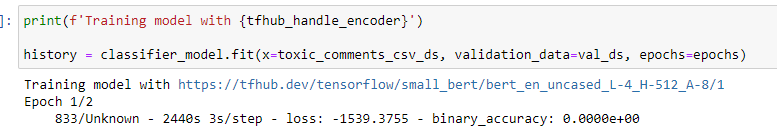

### Оценка моделей

In [455]:
loss, accuracy = classifier_model.evaluate(toxic_comments_csv_ds_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

     54/Unknown - 40s 716ms/step - loss: -5944.1006 - binary_accuracy: 0.0000e+00

KeyboardInterrupt: 

<div class="alert alert-block alert-info">

Комментарий студента V1: И здесь аналогично
    
</div>

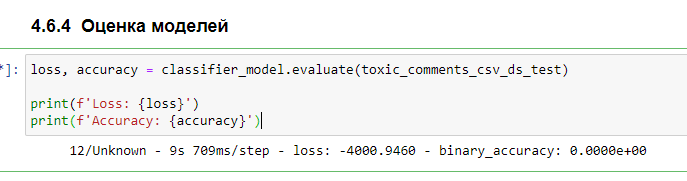

### Построим график точности и потери с течением времени

На основе объекта `History`, возвращаемого `model.fit()`. Вы можете построить график потерь при обучении и валидации для сравнения, а также точности обучения и валидации:

In [456]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

NameError: name 'history' is not defined

## Проверим на F1-метрику

In [504]:
# Каким образом можно вытянуть предсказания, если там выдает только функцию потери?

In [505]:
# В процессе

# Выводы

In [506]:
# В процессе

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны